In [1]:
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import upsetplot as up
import ast
from scipy.stats import fisher_exact




from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

In [ ]:
main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_ids = load_tissue_ids(config)


In [3]:
gwas_meta = pd.read_csv(config['gwas_meta'], sep='\t', header=0)
gwas_ids = gwas_meta['Tag']

In [4]:
coloc_cutoff = .75

## load in the completed cluster gwas colocs

In [5]:

# Function to recursively get list of files ending with .qtl_gwas.txt
# this should later be updated to exclude the emp files

#version for only complete results 
def get_files(directory):
    file_list = []
    for root, directories, files in os.walk(directory):
        if not 'temp' in root:
            for file in files:
                if "susie_True" in file:
                    file_list.append(os.path.join(root, file))
    return file_list


# # # version for partially complete results too
# def get_files(directory):
#     file_list = []
#     for root, directories, files in os.walk(directory):
#         for file in files:
#             if "susie_TRUE" in file:
#                 file_list.append(os.path.join(root, file))
#     return file_list

# Get the list of files
coloc_file_list = get_files('{}/{}'.format(prefix, 'output/proteincoding_main/coloc/gwas'))
len(coloc_file_list)

406

In [6]:
from pandas.errors import EmptyDataError  # Import EmptyDataError

# Load each file into a DataFrame and concatenate them
cluster_colocs = []
for cluster_file in tqdm(coloc_file_list):
    try:
        cluster_coloc = pd.read_csv(cluster_file, sep='\t')  # Assuming tab-separated file
    except EmptyDataError as e:
        print(f"File is empty: {cluster_file}") 
    tissue_id = cluster_file.split('/')[9]
    cluster_coloc['tissue_id'] = tissue_id
    cluster_colocs.append(cluster_coloc)

# Concatenate all DataFrames into a single DataFrame
gwas_coloc = pd.concat(cluster_colocs, ignore_index=True)
gwas_coloc['cluster_id'] = np.where(gwas_coloc['qtl_id'].str.contains('_e'), gwas_coloc['qtl_id'].str.split('_e').str[0], gwas_coloc['qtl_id'].str.split('_pc').str[0])
# Print the combined DataFrame
gwas_coloc.head()

  0%|          | 0/406 [00:00<?, ?it/s]

File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Muscle_Skeletal/Muscle_Skeletal.v8.EGG_Pubertal_growth_10F.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Muscle_Skeletal/Muscle_Skeletal.v8.GEFOS_Forearm.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Muscle_Skeletal/Muscle_Skeletal.v8.GPC-NEO-NEUROTICISM.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Skin_Sun_Exposed_Lower_leg/Skin_Sun_Exposed_Lower_leg.v8.GEFOS_Forearm.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Thyroid/Thyroid.v8.GPC-NEO-NEUROTICISM.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/coloc/gwas/Thyroid/Thyroid.v8.EGG_Pubertal_growth_10F.susie_True.gwas_coloc.txt
File is empty: /home/klawren/oak/pcqtls/output/proteincoding_main/

,gwas_id,qtl_id,tissue_id,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,idx1,idx2,gwas_cs_is,qtl_cs_is,cluster_id
0,Astle_et_al_2016_Reticulocyte_count,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,Muscle_Skeletal,4512.0,chr1_46026472_C_T_b38,chr1_46821969_C_T_b38,2.863018e-08,1.255896e-02,2.250660e-06,0.987277,1.616096e-04,1.0,1.0,1.0,1.0,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...
1,Astle_et_al_2016_Reticulocyte_count,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,Muscle_Skeletal,4512.0,chr1_46026472_C_T_b38,chr1_46802854_G_A_b38,1.032652e-15,4.529844e-10,2.279657e-06,0.999998,6.386286e-08,1.0,1.0,1.0,1.0,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...
2,Astle_et_al_2016_Reticulocyte_count,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,Muscle_Skeletal,4512.0,chr1_46026472_C_T_b38,chr1_47110482_G_A_b38,1.410500e-09,6.187319e-04,2.278169e-06,0.999345,3.424755e-05,1.0,1.0,1.0,1.0,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...
3,Astle_et_al_2016_Reticulocyte_count,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...,Muscle_Skeletal,4512.0,chr1_46026472_C_T_b38,chr1_46819478_G_A_b38,8.869654e-15,3.890775e-09,2.279657e-06,0.999998,6.066613e-08,1.0,1.0,1.0,1.0,ENSG00000162365.11_ENSG00000186160.4_ENSG00000...
4,Astle_et_al_2016_Reticulocyte_count,ENSG00000163239.12_ENSG00000169291.9_e_ENSG000...,Muscle_Skeletal,3285.0,chr1_155301642_TA_T_b38,chr1_154473722_T_C_b38,1.156131e-17,2.380523e-03,4.844953e-15,0.997596,2.322400e-05,1.0,1.0,1.0,1.0,ENSG00000163239.12_ENSG00000169291.9


In [7]:
# duplicate rows from intermediate write outs
gwas_coloc = gwas_coloc.drop_duplicates()
len(gwas_coloc)

198359

some plots about coloc prob distributions

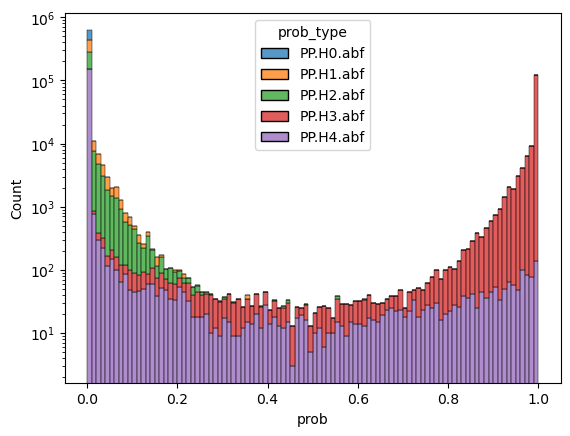

In [8]:
gwas_coloc_melted  = gwas_coloc.melt(id_vars=['tissue_id', 'gwas_id', 'qtl_id'], value_name='prob', var_name='prob_type', value_vars=[f'PP.H{i}.abf' for i in range(5)])
ax = sns.histplot(gwas_coloc_melted, x='prob', hue='prob_type', bins=100, multiple='stack')
ax.set_yscale('log')

<AxesSubplot: xlabel='count', ylabel='highest_prob'>

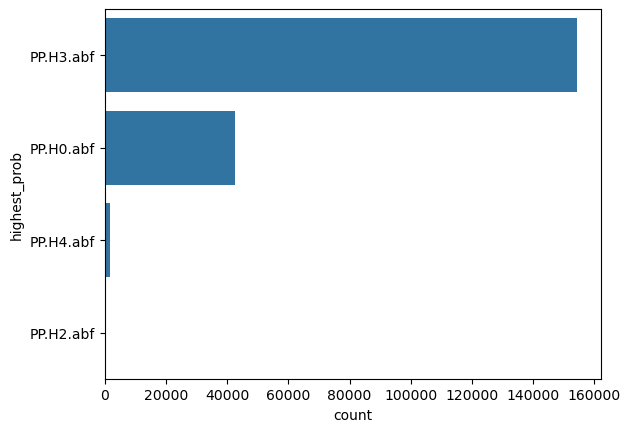

In [9]:
# plot of which hypothesis is most probable for each row
gwas_coloc['highest_prob'] = gwas_coloc[['PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf']].idxmax(axis=1)
sns.countplot(gwas_coloc['highest_prob'])

In [10]:
# make ids for each credible set in the qtl and gwas
# if susie
gwas_coloc['gwas_cs_id'] = gwas_coloc['gwas_id'] + '_cs_' + gwas_coloc['gwas_cs_is'].astype(int).astype(str) + '_cluster_' + gwas_coloc['cluster_id']
gwas_coloc['qtl_cs_id'] = gwas_coloc['qtl_id'] + '_cs_' + gwas_coloc['qtl_cs_is'].astype(int).astype(str) + '_cluster_' + gwas_coloc['cluster_id']

gwas_coloc['type'] = np.where(gwas_coloc['qtl_cs_id'].str.contains('_pc'), 'pcqtl', 'eqtl')

In [11]:
# break this down by pc number
gwas_coloc['pc_num'] = np.where(gwas_coloc['type']=='pcqtl',  gwas_coloc['qtl_id'].str.split('_pc').str[-1], 0)
gwas_coloc['pc_num'] = gwas_coloc['pc_num'].astype(int)
gwas_coloc['cluster_size'] = gwas_coloc['qtl_id'].str.split('_').apply(len) -1
# split first, last, and middle pcs
gwas_coloc['pc_order'] = 'middle_pc'
gwas_coloc.loc[gwas_coloc['pc_num'] == gwas_coloc['cluster_size'],'pc_order'] = 'last_pc'
gwas_coloc.loc[gwas_coloc['pc_num'] == 1,'pc_order'] = 'first_pc'
gwas_coloc.loc[gwas_coloc['type'] == 'eqtl','pc_order'] = 'eqtl'

In [12]:
# fill in nas
# not sure why there are so many nas :(
gwas_coloc[['PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf']] = gwas_coloc[['PP.H0.abf', 'PP.H1.abf', 'PP.H2.abf', 'PP.H3.abf', 'PP.H4.abf']].fillna(0)

In [13]:
# aggregate over egenes and pcs
gwas_coloc_e = gwas_coloc[gwas_coloc['type']=='eqtl']
gwas_coloc_pc = gwas_coloc[gwas_coloc['type']=='pcqtl']
max_pph4_indices_e = gwas_coloc_e.groupby('gwas_cs_id')['PP.H4.abf'].idxmax()
max_pph4_indices_pc = gwas_coloc_pc.groupby('gwas_cs_id')['PP.H4.abf'].idxmax()

eqtl_pp4 = gwas_coloc.loc[max_pph4_indices_e, ['gwas_cs_id', 'PP.H4.abf', 'pc_order']]
pcqtl_pp4 = gwas_coloc.loc[max_pph4_indices_pc, ['gwas_cs_id', 'PP.H4.abf', 'pc_order']]
pph4 = pd.merge(pcqtl_pp4, eqtl_pp4, suffixes=['_pc','_e'], left_on='gwas_cs_id', right_on='gwas_cs_id')
pph4['colocalized'] = (pph4['PP.H4.abf_e'] > coloc_cutoff)| (pph4['PP.H4.abf_pc'] >coloc_cutoff )
pph4['coloc_color'] = np.where(pph4['PP.H4.abf_e'] > coloc_cutoff, 
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'Both', 'eQTL only'),
                               np.where(pph4['PP.H4.abf_pc'] >coloc_cutoff, 'pcQTL only', 'Neither'))
len(pph4)

28541

In [14]:
print('pc only:{}'.format(((pph4['PP.H4.abf_pc']>coloc_cutoff) & (pph4['PP.H4.abf_e']<coloc_cutoff)).sum()/sum(pph4['colocalized'])))
print('e only:{}'.format(((pph4['PP.H4.abf_e']>coloc_cutoff) & (pph4['PP.H4.abf_pc']<coloc_cutoff)).sum()/sum(pph4['colocalized'])))
print('both: {}'.format(((pph4['coloc_color']=='Both')).sum()/sum(pph4['colocalized'])))
print('neither: {}'.format(((pph4['coloc_color']=='Neither')).sum()/len(pph4)))

pc only:0.2643253234750462
e only:0.23105360443622922
both: 0.5046210720887245
neither: 0.9810448127255527


In [15]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 1000

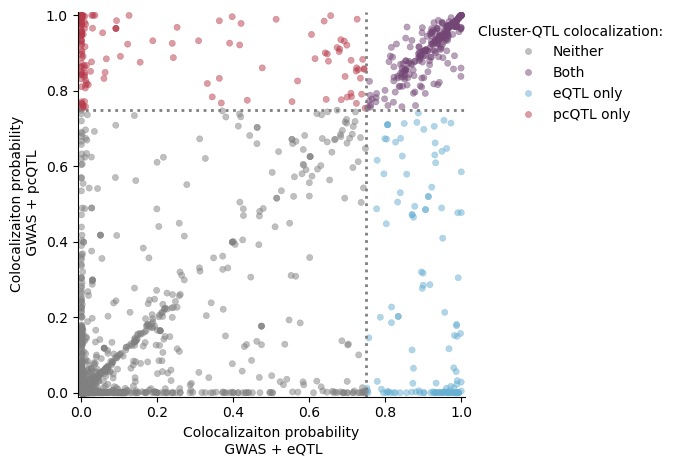

In [16]:

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(pph4[pph4['coloc_color'].isin(['Neither', 'Both', 'eQTL only', 'pcQTL only'])], x='PP.H4.abf_e', y='PP.H4.abf_pc', hue='coloc_color', ax=ax, s=20, alpha=.5,
             palette={'pcQTL only':'#B83A4B', 'eQTL only':'#67AFD2', 'Both':'#734675', 'Neither':'grey'}, edgecolor=None,
             hue_order = ['Neither', 'Both', 'eQTL only', 'pcQTL only'])
ax.axhline(.75, color='grey', linestyle=':', linewidth=2)
ax.axvline(.75, color='grey', linestyle=':', linewidth=2)

ax.set_xlabel('Colocalizaiton probability\n GWAS + eQTL')
ax.set_ylabel('Colocalizaiton probability\n GWAS + pcQTL')

ax.set_xlim(-.01, 1.01)
ax.set_ylim(-.01,1.01)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('Cluster-QTL colocalization: ')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [17]:
pph4['pc_only'] = (pph4['PP.H4.abf_pc']>coloc_cutoff) & (pph4['PP.H4.abf_e']<coloc_cutoff)
pph4['e_only'] = (pph4['PP.H4.abf_e']>coloc_cutoff) & (pph4['PP.H4.abf_pc']<coloc_cutoff)
pph4['only_label'] = np.where(pph4['PP.H4.abf_pc']>coloc_cutoff, np.where(pph4['PP.H4.abf_e']>coloc_cutoff, 'both', 'pc_only'), np.where(pph4['PP.H4.abf_e']>coloc_cutoff, 'e_only', 'neither'))

<AxesSubplot: xlabel='pc_order_pc', ylabel='Percent'>

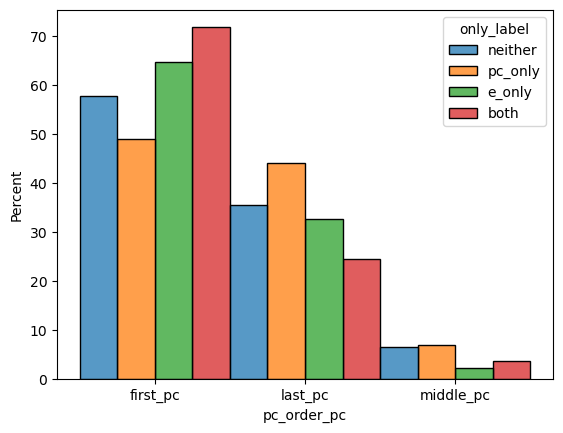

In [18]:
sns.histplot(pph4, x='pc_order_pc', hue='only_label', stat='percent', common_norm=False, multiple='dodge')

first look just at the number of hits, not trying to overlap pc and eqtls 

In [19]:
# count number of e and pc hits
gwas_coloc_hits = gwas_coloc[gwas_coloc['PP.H4.abf'] > coloc_cutoff].reset_index()
print('number pcqtls total (could overlap): {}'.format(sum(gwas_coloc_hits['qtl_cs_id'].str.contains('_pc'))))
print('number eqtls total (could overlap): {}'.format(sum(gwas_coloc_hits['qtl_cs_id'].str.contains('_e'))))

number pcqtls total (could overlap): 584
number eqtls total (could overlap): 579


<AxesSubplot: xlabel='Count', ylabel='tissue_id'>

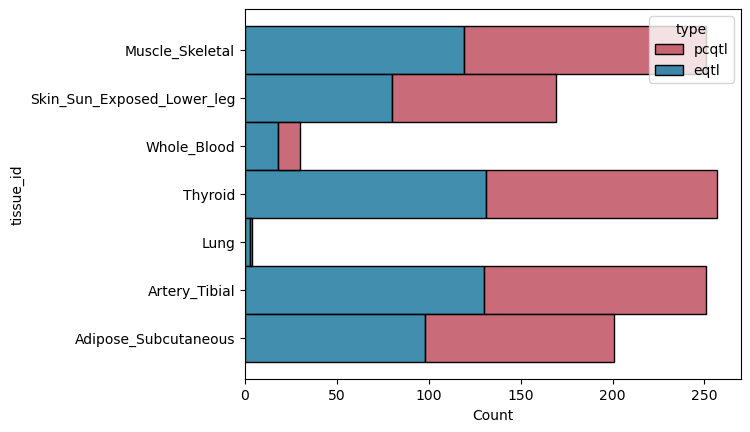

In [20]:
# raw counts (could overlap)
gwas_coloc_hits['type'] = np.where(gwas_coloc_hits['qtl_cs_id'].str.contains('_pc'), 'pcqtl', 'eqtl')
sns.histplot(gwas_coloc_hits, hue='type', y='tissue_id', multiple='stack', hue_order=['pcqtl','eqtl'], 
             palette=('#B83A4B', '#016895'))

In [21]:
gwas_coloc_counts = gwas_coloc_hits.groupby('tissue_id').agg({'qtl_cs_id':'unique'})
gwas_coloc_counts['num_e'] = gwas_coloc_counts['qtl_cs_id'].astype(str).str.count('_e')
gwas_coloc_counts['num_pc'] = gwas_coloc_counts['qtl_cs_id'].astype(str).str.count('_pc')
gwas_coloc_counts['num_colocs'] = gwas_coloc_counts['num_e'] + gwas_coloc_counts['num_pc']

gwas_coloc_counts

,qtl_cs_id,num_e,num_pc,num_colocs
tissue_id,,,,
Adipose_Subcutaneous,[ENSG00000125510.15_ENSG00000171700.13_e_ENSG0...,65,62,127
Artery_Tibial,[ENSG00000114850.6_ENSG00000163659.12_e_ENSG00...,72,69,141
Lung,[ENSG00000152348.15_ENSG00000186468.12_ENSG000...,2,1,3
Muscle_Skeletal,[ENSG00000105971.14_ENSG00000105974.11_e_ENSG0...,72,80,152
Skin_Sun_Exposed_Lower_leg,[ENSG00000132321.16_ENSG00000144476.5_e_ENSG00...,55,58,113
Thyroid,[ENSG00000134824.13_ENSG00000149485.18_pc2_cs_...,98,99,197
Whole_Blood,[ENSG00000157870.14_ENSG00000157873.17_pc2_cs_...,11,7,18


/local/scratch/klawren/slrmtmp.46880659/ipykernel_55892/1038350952.py:8: UserWarning: The palette list has more values (13) than needed (7), which may not be intended.
  ax = sns.barplot(gwas_coloc_counts, x='num_colocs', hue='tissue_id', y='tissue_id', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)
/local/scratch/klawren/slrmtmp.46880659/ipykernel_55892/1038350952.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


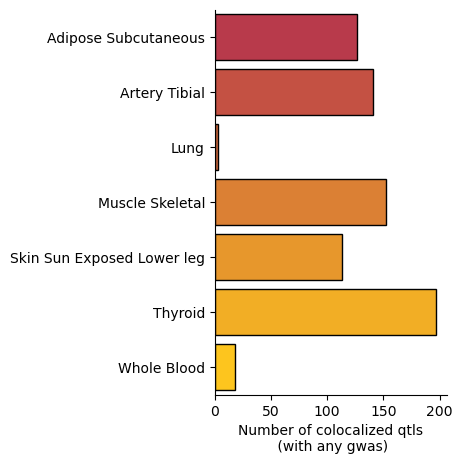

In [22]:
# make a simple plot with total colocs in each tissue (the signals could overlap)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


# plot showing number of clusters in each tissue

fig, ax = plt.subplots(figsize=(3,5))
ax = sns.barplot(gwas_coloc_counts, x='num_colocs', hue='tissue_id', y='tissue_id', palette=tissue_pal, saturation=1, edgecolor='k', width=.85, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

ax.set_xlabel('Number of colocalized qtls\n (with any gwas)')
ax.set_ylabel('')

plt.show()

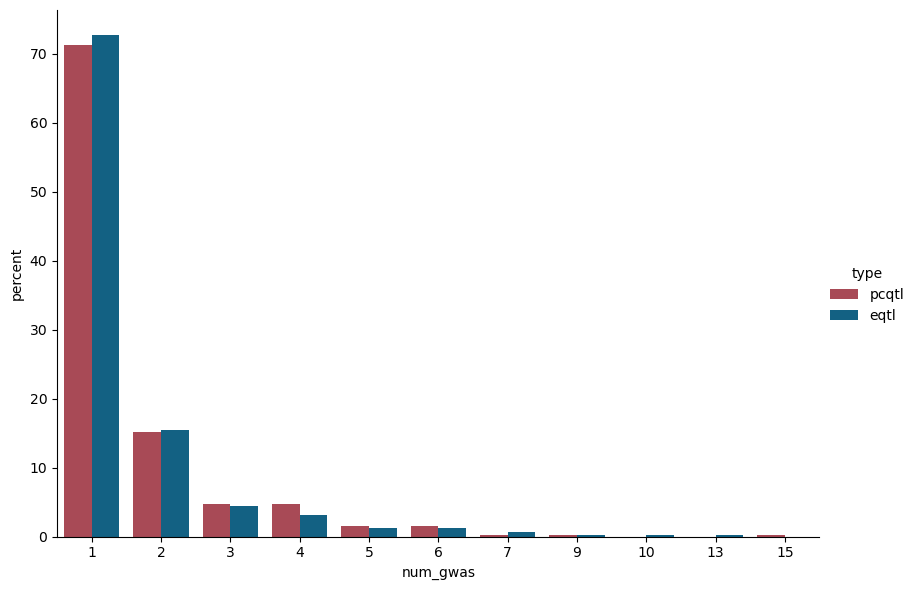

In [23]:
# number of gwas hits per qtl
gwas_grouped_colocs = gwas_coloc_hits.groupby('qtl_cs_id').agg({'gwas_cs_id':'unique', 
                                                             'type':'first'})
gwas_grouped_colocs['num_gwas'] = gwas_grouped_colocs['gwas_cs_id'].apply(len)
data_to_plot = gwas_grouped_colocs.groupby('type')['num_gwas'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, x='num_gwas',y='percent',hue='type',kind='bar',height=6, aspect=1.4, hue_order=['pcqtl','eqtl'], palette=('#B83A4B', '#016895'))


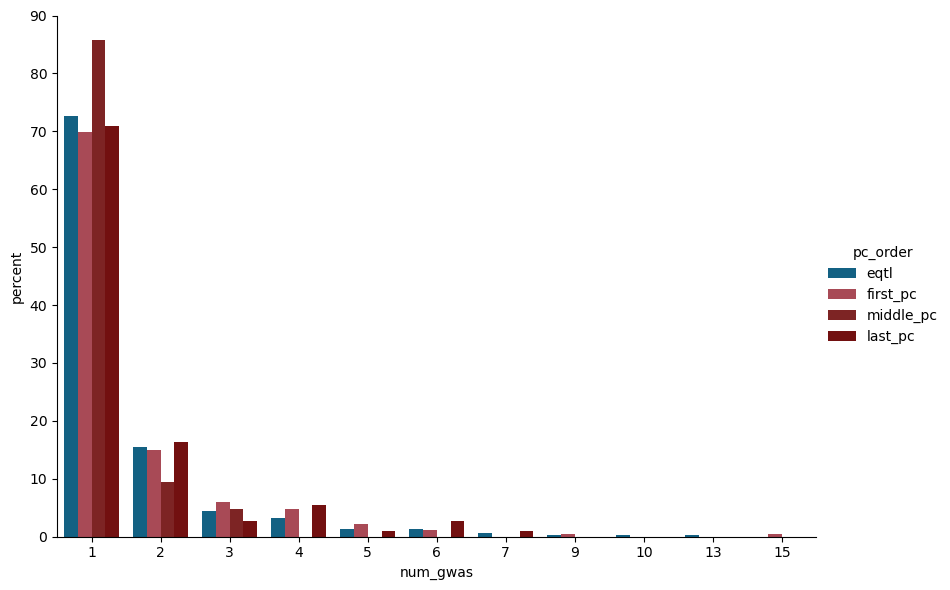

In [24]:
# break this down by pc number
gwas_coloc_hits['pc_num'] = np.where(gwas_coloc_hits['type']=='pcqtl',  gwas_coloc_hits['qtl_id'].str.split('_pc').str[-1], 0)
gwas_coloc_hits['pc_num'] = gwas_coloc_hits['pc_num'].astype(int)
# add in cluster size
gwas_coloc_hits['cluster_size'] = gwas_coloc_hits['qtl_id'].str.split('_').apply(len) -1
# split first, last, and middle pcs
gwas_coloc_hits['pc_order'] = 'middle_pc'
gwas_coloc_hits.loc[gwas_coloc_hits['pc_num'] == gwas_coloc_hits['cluster_size'],'pc_order'] = 'last_pc'
gwas_coloc_hits.loc[gwas_coloc_hits['pc_num'] == 1,'pc_order'] = 'first_pc'
gwas_coloc_hits.loc[gwas_coloc_hits['type'] == 'eqtl','pc_order'] = 'eqtl'

# number of gwas hits per qtl
gwas_grouped_colocs = gwas_coloc_hits.groupby('qtl_cs_id').agg({'gwas_cs_id':'unique', 
                                                             'pc_order':'first'})
gwas_grouped_colocs['num_gwas'] = gwas_grouped_colocs['gwas_cs_id'].apply(len)
data_to_plot = gwas_grouped_colocs.groupby('pc_order')['num_gwas'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, x='num_gwas',y='percent',hue='pc_order',kind='bar',height=6, aspect=1.4, 
            hue_order = ['eqtl', 'first_pc', 'middle_pc', 'last_pc'], 
            palette={'eqtl':'#016895', 'first_pc':'#B83A4B', 'middle_pc':'#8C1515', 'last_pc':'#820000'})


now combine around gwas signals - does each one colocalize to a pcqtl, an eqtl, or multiple pcqtls?

In [52]:
# group by qtl signal
gwas_coloc_overlap = gwas_coloc_hits.groupby(['gwas_cs_id', 'tissue_id']).agg({'qtl_cs_id':'unique', 'gwas_id':'first'}).reset_index()

# count things
gwas_coloc_overlap['num_hits'] = gwas_coloc_overlap['qtl_cs_id'].apply(len)
gwas_coloc_overlap['num_eqtl'] = gwas_coloc_overlap['qtl_cs_id'].astype(str).str.count('_e')
gwas_coloc_overlap['num_pcqtl'] = gwas_coloc_overlap['qtl_cs_id'].astype(str).str.count('_pc')
gwas_coloc_overlap['hit_type'] = np.where(gwas_coloc_overlap['num_eqtl']>0, np.where(gwas_coloc_overlap['num_pcqtl']>0, 'both', 'eqtl_only'), 
                                          np.where(gwas_coloc_overlap['num_pcqtl']>0, 'pcqtl_only', 'neither??'))

/local/scratch/klawren/slrmtmp.46831810/ipykernel_35679/4120781565.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


Text(0.5, 0, 'Number of colocalized QTLs (each gwas counts seperately)')

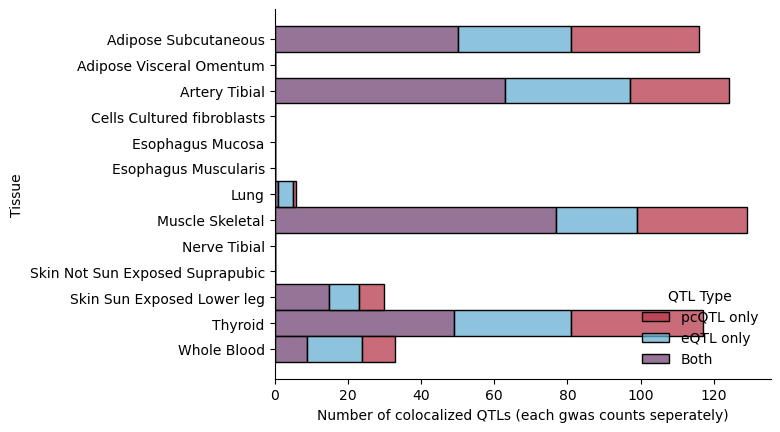

In [53]:
# histogram with gtle type
gwas_coloc_overlap['tissue_id_ordered'] = pd.Categorical(gwas_coloc_overlap['tissue_id'], tissue_ids)


ax = sns.histplot(gwas_coloc_overlap, y='tissue_id_ordered', hue='hit_type', multiple='stack', 
             hue_order=['pcqtl_only','eqtl_only', 'both'], 
             palette=('#B83A4B', '#67AFD2', '#734675'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)
ax.set_ylabel('Tissue')

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

plt.gca().get_legend().set_frame_on(False)




ax.set_xlabel('Number of colocalized QTLs (each gwas counts seperately)')


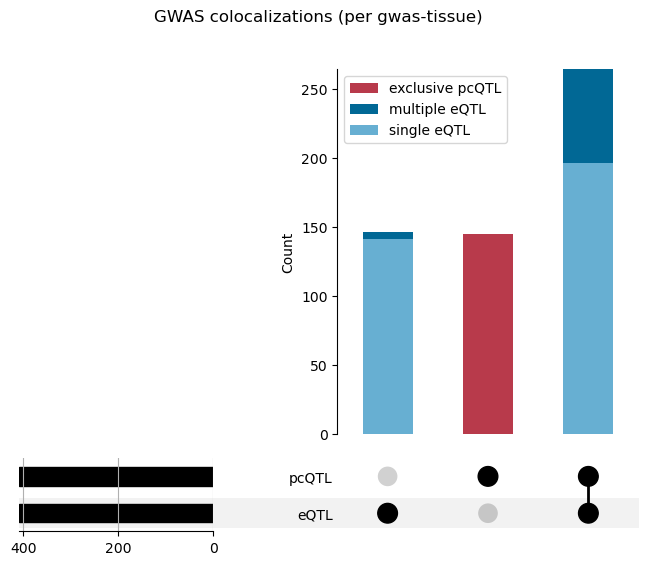

In [54]:
# make indicator columns 
gwas_coloc_overlap['pcQTL'] = gwas_coloc_overlap['num_pcqtl'] > 0
gwas_coloc_overlap['eQTL'] = gwas_coloc_overlap['num_eqtl'] > 0

# multiple egenes
gwas_coloc_overlap['multiple_e_shared'] = gwas_coloc_overlap['num_eqtl']>1  

upset_to_plot = gwas_coloc_overlap.set_index('eQTL').set_index('pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations (per gwas-tissue)')
plt.show()

### heatmap for gwas trait/tissue enrichments

In [55]:
observed_counts = gwas_coloc[gwas_coloc['type'] =='eqtl'].groupby(['gwas_cs_id', 'tissue_id']).agg({'qtl_cs_id':'unique', 'gwas_id':'first'}).pivot_table(index='tissue_id', columns='gwas_id', aggfunc='size', fill_value=0)
background_counts = gwas_coloc[gwas_coloc['type'] =='eqtl'].pivot_table(index='tissue_id', columns='gwas_id', aggfunc='size', fill_value=0)

# Step 2: Calculate enrichment p-values
enrichment_p_values = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)
fisher_odds = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)

for tissue in observed_counts.index:
    for gwas in observed_counts.columns:
        # Create a 2x2 contingency table
        observed = observed_counts.loc[tissue, gwas]
        background = background_counts.loc[tissue, gwas]
        
        # Total occurrences (observed + not observed) for both observed and background
        total_observed = observed_counts.loc[tissue].sum()
        total_background = background_counts.loc[tissue].sum()
        
        # Not observed counts
        not_observed = total_observed - observed
        not_background = total_background - background
        
        contingency_table = np.array([[observed, not_observed],
                                       [background, not_background]])
        
        # Perform Fisher's Exact Test
        res, p_value = fisher_exact(contingency_table)  # Use "greater" for enrichment
        enrichment_p_values.loc[tissue, gwas] = -np.log10(p_value)
        fisher_odds.loc[tissue, gwas] = np.log(res)

(enrichment_p_values >-np.log10(.05)).sum().sum()

30

In [56]:
observed_counts = gwas_coloc[gwas_coloc['type'] =='pcqtl'].groupby(['gwas_cs_id', 'tissue_id']).agg({'qtl_cs_id':'unique', 'gwas_id':'first'}).pivot_table(index='tissue_id', columns='gwas_id', aggfunc='size', fill_value=0)
background_counts = gwas_coloc[gwas_coloc['type'] =='pcqtl'].pivot_table(index='tissue_id', columns='gwas_id', aggfunc='size', fill_value=0)

# Step 2: Calculate enrichment p-values
enrichment_p_values = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)
fisher_odds = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)

for tissue in observed_counts.index:
    for gwas in observed_counts.columns:
        # Create a 2x2 contingency table
        observed = observed_counts.loc[tissue, gwas]
        background = background_counts.loc[tissue, gwas]
        
        # Total occurrences (observed + not observed) for both observed and background
        total_observed = observed_counts.loc[tissue].sum()
        total_background = background_counts.loc[tissue].sum()
        
        # Not observed counts
        not_observed = total_observed - observed
        not_background = total_background - background
        
        contingency_table = np.array([[observed, not_observed],
                                       [background, not_background]])
        
        # Perform Fisher's Exact Test
        res, p_value = fisher_exact(contingency_table)  # Use "greater" for enrichment
        enrichment_p_values.loc[tissue, gwas] = -np.log10(p_value)
        fisher_odds.loc[tissue, gwas] = np.log(res)

(enrichment_p_values >-np.log10(.05)).sum().sum()

38

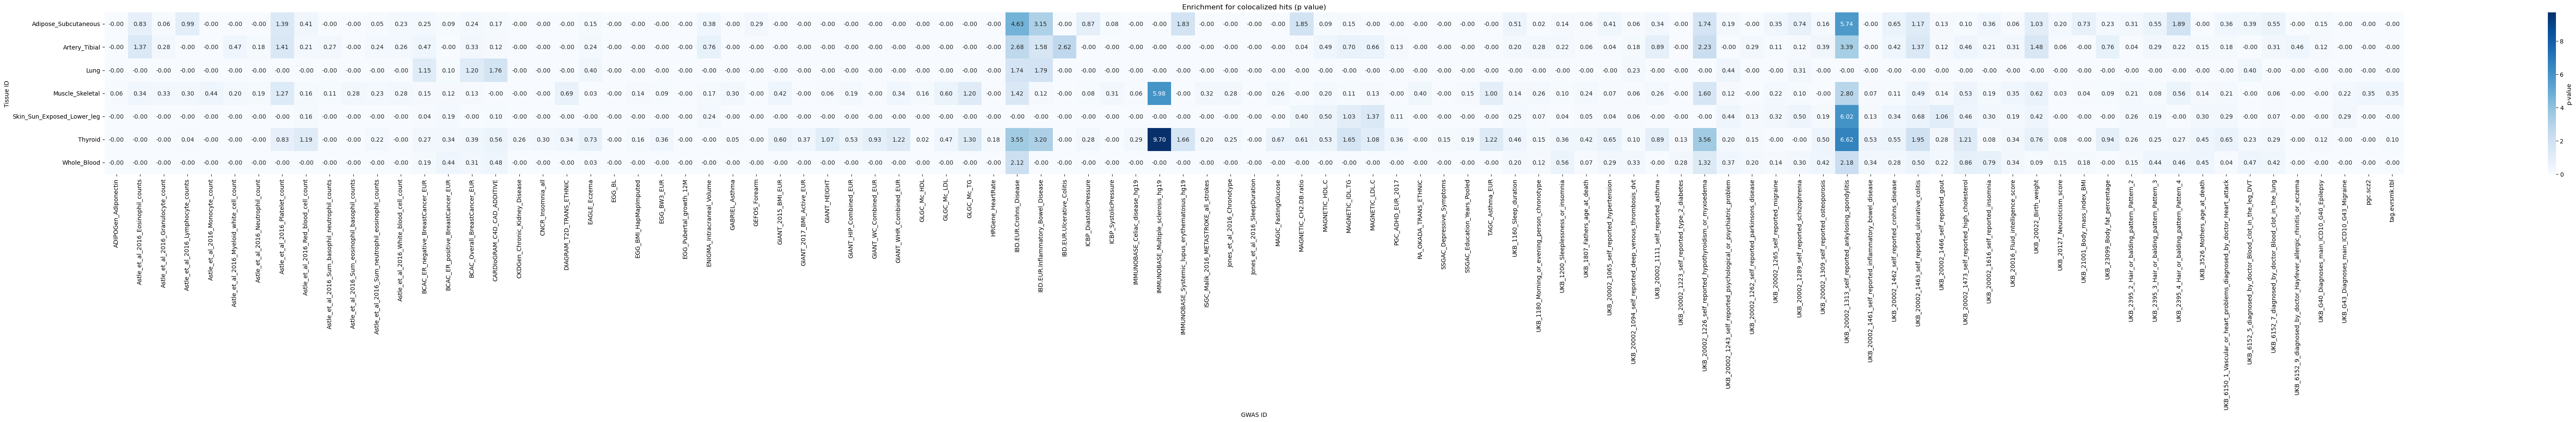

In [57]:
plt.figure(figsize=(70, 10))
max_diff = abs(fisher_odds).max().max()
sns.heatmap(enrichment_p_values.astype(float), annot=True, cmap='Blues', fmt=".2f", 
            cbar_kws={'label': 'p-value'})

plt.title('Enrichment for colocalized hits (p value)')
plt.xlabel('GWAS ID')
plt.ylabel('Tissue ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

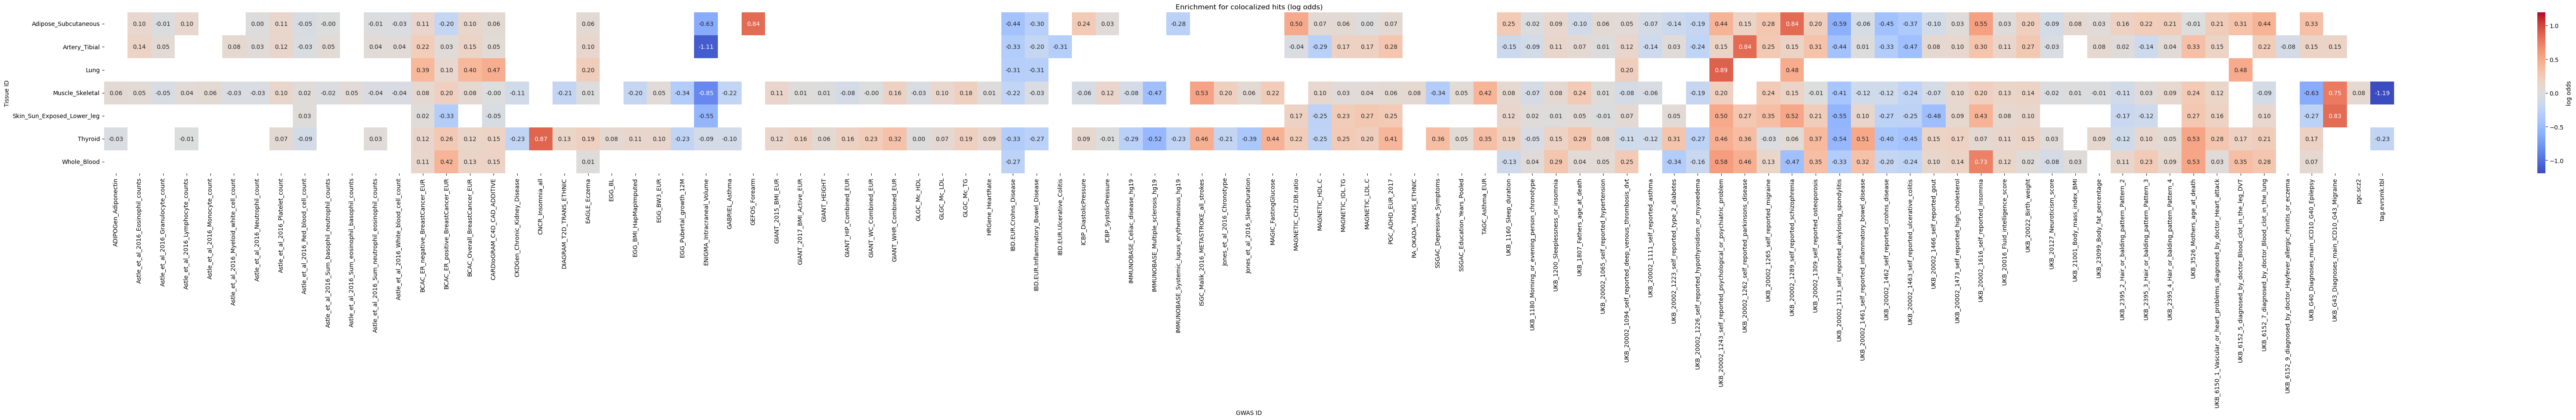

In [59]:
plt.figure(figsize=(70, 10))
max_diff = abs(fisher_odds).max().max()
sns.heatmap(fisher_odds.astype(float), annot=True, cmap='coolwarm', fmt=".2f", 
            cbar_kws={'label': 'log odds'}, 
            vmin=-max_diff, 
            vmax=max_diff)

plt.title('Enrichment for colocalized hits (log odds)')
plt.xlabel('GWAS ID')
plt.ylabel('Tissue ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

In [83]:
# add trait categories
category_dict = {
    'Anthropometric': ['UKB_1160_Sleep_duration', 'UKB_20016_Fluid_intelligence_score', 
                  'UKB_21001_Body_mass_index_BMI', 'UKB_3526_Mothers_age_at_death', 
                  'UKB_50_Standing_height', 'EGG_BMI_HapMapImputed', 'EGG_Pubertal_growth_10F', 
                  'EGG_Pubertal_growth_12M', 'GEFOS_Forearm', 'GIANT_2015_BMI_EUR', 'GIANT_HEIGHT', 
                  'GIANT_HIP_Combined_EUR', 'GIANT_WC_Combined_EUR', 'GIANT_WHR_Combined_EUR', 
                  'ISGC_Malik_2016_METASTROKE_all_strokes', 'Jones_et_al_2016_SleepDuration', 
                  'MAGNETIC_CH2.DB.ratio', 'MAGNETIC_HDL.C', 'MAGNETIC_IDL.TG', 'MAGNETIC_LDL.C', 
                  'MAGIC_FastingGlucose', 'MAGIC_ln_FastingInsulin', 
                  'SSGAC_Depressive_Symptoms', 'SSGAC_Education_Years_Pooled'],
    
    'Cardiometabolic': ['UKB_20002_1094_self_reported_deep_venous_thrombosis_dvt', 
                   'UKB_20002_1065_self_reported_hypertension', 
                   'UKB_20002_1222_self_reported_type_1_diabetes', 
                   'UKB_20002_1223_self_reported_type_2_diabetes', 'CARDIoGRAM_C4D_CAD_ADDITIVE', 
                   'CKDGen_Chronic_Kidney_Disease', 'DIAGRAM_T2D_TRANS_ETHNIC', 
                   'GLGC_Mc_HDL', 'GLGC_Mc_LDL', 'GLGC_Mc_TG', 
                   'HRGene_HeartRate', 'RA_OKADA_TRANS_ETHNIC', 'ICBP_SystolicPressure', 
                   'ICBP_DiastolicPressure', 'TAGC_Asthma_EUR'],
    
    'Psychiatric_neurologic' : ['UKB_1180_Morning_or_evening_person_chronotype', 
                          'UKB_1200_Sleeplessness_or_insomnia', 
                          'UKB_20002_1243_self_reported_psychological_or_psychiatric_problem', 
                          'UKB_20002_1261_self_reported_multiple_sclerosis', 
                          'UKB_20002_1262_self_reported_parkinsons_disease', 
                          'UKB_20002_1289_self_reported_schizophrenia', 
                          'GPC-NEO-NEUROTICISM', 'ILAE_Genetic_generalised_epilepsy',  
                          'Jones_et_al_2016_Chronotype', 'PGC_ADHD_EUR_2017', 
                          'PGC_ASD_2017_CEU', 'pgc.scz2'],
    
    'Immune' : ['UKB_20002_1313_self_reported_ankylosing_spondylitis', 
          'UKB_20002_1452_self_reported_eczema_or_dermatitis', 
          'UKB_20002_1453_self_reported_psoriasis', 
          'UKB_20002_1461_self_reported_inflammatory_bowel_disease', 
          'UKB_20002_1462_self_reported_crohns_disease', 
          'UKB_20002_1463_self_reported_ulcerative_colitis', 
          'UKB_20002_1464_self_reported_rheumatoid_arthritis', 
          'IMMUNOBASE_Celiac_disease_hg19', 'IMMUNOBASE_Multiple_sclerosis_hg19', 
          'IMMUNOBASE_Systemic_lupus_erythematosus_hg19', 
          'IBD.EUR.Crohns_Disease', 'IBD.EUR.Inflammatory_Bowel_Disease', 
          'IBD.EUR.Ulcerative_Colitis'],
    
    'Cancer' : ['BCAC_ER_negative_BreastCancer_EUR', 'BCAC_ER_positive_BreastCancer_EUR', 
          'BCAC_Overall_BreastCancer_EUR'],
    
    'Others' : ['UKB_20002_1111_self_reported_asthma',  'UKB_20002_1154_self_reported_irritable_bowel_syndrome', 
          'UKB_20002_1466_self_reported_gout', 'UKB_20002_1473_self_reported_high_cholesterol', 
          'IGAP_Alzheimer', 'tag.evrsmk.tbl']
}

# Converting the dictionary into a pandas dataframe
trait_to_category = {trait: category for category, trait_list in category_dict.items() for trait in trait_list}
gwas_coloc['GWAS_category'] = gwas_coloc['gwas_id'].map(trait_to_category)


In [84]:
# combined over categories instead of individual gwas
observed_counts = gwas_coloc[gwas_coloc['type'] =='eqtl'].groupby(['gwas_cs_id', 'tissue_id']).agg({'qtl_cs_id':'unique', 'GWAS_category':'first'}).pivot_table(index='tissue_id', columns='GWAS_category', aggfunc='size', fill_value=0)
background_counts = gwas_coloc[gwas_coloc['type'] =='eqtl'].pivot_table(index='tissue_id', columns='GWAS_category', aggfunc='size', fill_value=0)

# Step 2: Calculate enrichment p-values
enrichment_p_values = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)
fisher_odds = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)

for tissue in observed_counts.index:
    for gwas in observed_counts.columns:
        # Create a 2x2 contingency table
        observed = observed_counts.loc[tissue, gwas]
        background = background_counts.loc[tissue, gwas]
        
        # Total occurrences (observed + not observed) for both observed and background
        total_observed = observed_counts.loc[tissue].sum()
        total_background = background_counts.loc[tissue].sum()
        
        # Not observed counts
        not_observed = total_observed - observed
        not_background = total_background - background
        
        contingency_table = np.array([[observed, not_observed],
                                       [background, not_background]])
        
        # Perform Fisher's Exact Test
        res, p_value = fisher_exact(contingency_table)  # Use "greater" for enrichment
        enrichment_p_values.loc[tissue, gwas] = -np.log10(p_value)
        fisher_odds.loc[tissue, gwas] = np.log(res)

(enrichment_p_values >-np.log10(.05)).sum().sum()


0

In [85]:
# combined over categories instead of individual gwas
observed_counts = gwas_coloc[gwas_coloc['type'] =='pcqtl'].groupby(['gwas_cs_id', 'tissue_id']).agg({'qtl_cs_id':'unique', 'GWAS_category':'first'}).pivot_table(index='tissue_id', columns='GWAS_category', aggfunc='size', fill_value=0)
background_counts = gwas_coloc[gwas_coloc['type'] =='pcqtl'].pivot_table(index='tissue_id', columns='GWAS_category', aggfunc='size', fill_value=0)

# Step 2: Calculate enrichment p-values
enrichment_p_values = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)
fisher_odds = pd.DataFrame(index=observed_counts.index, columns=observed_counts.columns)

for tissue in observed_counts.index:
    for gwas in observed_counts.columns:
        # Create a 2x2 contingency table
        observed = observed_counts.loc[tissue, gwas]
        background = background_counts.loc[tissue, gwas]
        
        # Total occurrences (observed + not observed) for both observed and background
        total_observed = observed_counts.loc[tissue].sum()
        total_background = background_counts.loc[tissue].sum()
        
        # Not observed counts
        not_observed = total_observed - observed
        not_background = total_background - background
        
        contingency_table = np.array([[observed, not_observed],
                                       [background, not_background]])
        
        # Perform Fisher's Exact Test
        res, p_value = fisher_exact(contingency_table)  # Use "greater" for enrichment
        enrichment_p_values.loc[tissue, gwas] = -np.log10(p_value)
        fisher_odds.loc[tissue, gwas] = np.log(res)

(enrichment_p_values >-np.log10(.05)).sum().sum()


0

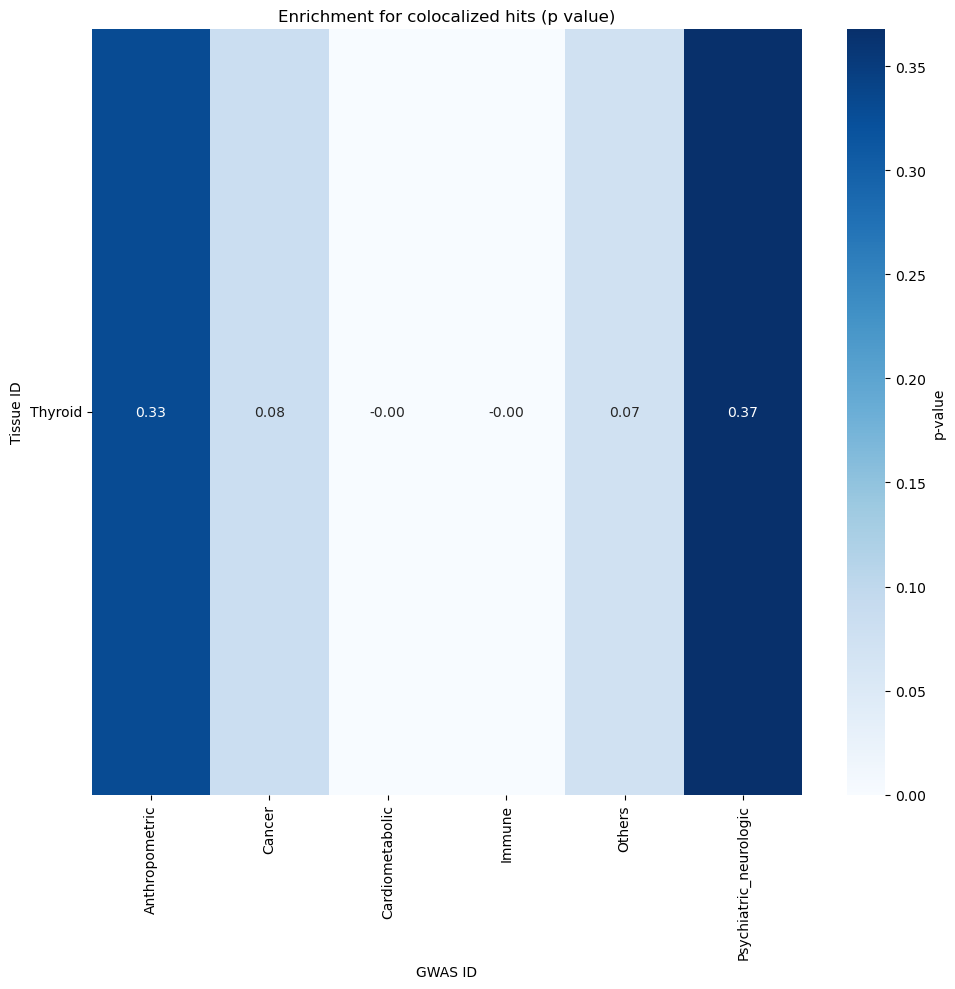

In [86]:
plt.figure(figsize=(10, 10))
max_diff = abs(fisher_odds).max().max()
sns.heatmap(enrichment_p_values.astype(float), annot=True, cmap='Blues', fmt=".2f", 
            cbar_kws={'label': 'p-value'})

plt.title('Enrichment for colocalized hits (p value)')
plt.xlabel('GWAS ID')
plt.ylabel('Tissue ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

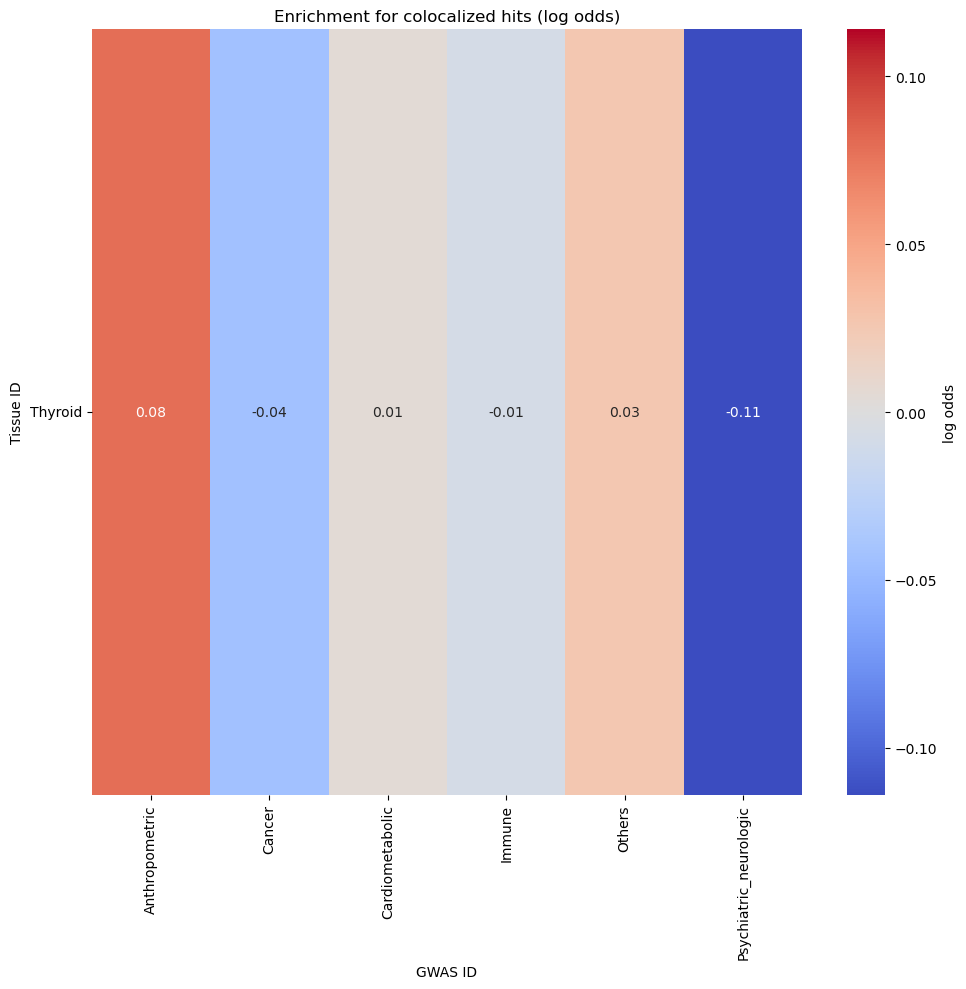

In [87]:
plt.figure(figsize=(10, 10))
max_diff = abs(fisher_odds).max().max()
sns.heatmap(fisher_odds.astype(float), annot=True, cmap='coolwarm', fmt=".2f", 
            cbar_kws={'label': 'log odds'}, 
            vmin=-max_diff, 
            vmax=max_diff)

plt.title('Enrichment for colocalized hits (log odds)')
plt.xlabel('GWAS ID')
plt.ylabel('Tissue ID')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

### coloc sets

now make it  so that each gwas doesn't count seperately by combining into groups of gwas and qtl signals

In [60]:
# something about tissue sharing??
gwas_coloc_hits['gwas_tissue_cs_id'] = gwas_coloc_hits['gwas_cs_id'] + '_tissue_' + gwas_coloc_hits['tissue_id']
gwas_coloc_hits['qtl_tissue_cs_id'] = gwas_coloc_hits['qtl_cs_id'] + '_tissue_' + gwas_coloc_hits['tissue_id']

qtl_grouped_colocs = gwas_coloc_hits.groupby('qtl_tissue_cs_id').agg({'gwas_tissue_cs_id':'unique'})
gwas_grouped_colocs = gwas_coloc_hits.groupby('gwas_tissue_cs_id').agg({'qtl_tissue_cs_id':'unique'})

In [61]:
qtl_sets = []
gwas_sets = []
for idx, row in gwas_grouped_colocs.iterrows():
    qtl_set = set(row['qtl_tissue_cs_id'].astype(list))
    new_qtls = 1
    new_gwas = 1
    gwas_set = set([idx])
    # expand the set to all overlapping qtls and gwas
    while ((new_qtls > 0) | (new_gwas > 1)):
        gwas_set_old = gwas_set
        qtl_set_old = qtl_set
        for gwas_cs_id in gwas_set:
            qtl_set = set(np.append(list(qtl_set), gwas_grouped_colocs.loc[gwas_cs_id,'qtl_tissue_cs_id']))
        new_qtls = len(qtl_set) - len(qtl_set_old)
        for qtl_cs_id in qtl_set:
            gwas_set = set(np.append(list(gwas_set), qtl_grouped_colocs.loc[qtl_cs_id,'gwas_tissue_cs_id']))
        new_gwas = len(gwas_set) - len(gwas_set_old)

    qtl_sets.append(set(qtl_set))
    gwas_sets.append(set(gwas_set))


coloc_sets = pd.DataFrame({'gwas_sets':gwas_sets, 
              'qtl_sets':qtl_sets})

coloc_sets['sorted_gwas_sets'] = coloc_sets['gwas_sets'].apply(lambda x: sorted(list(x))).astype(str)
coloc_sets['sorted_qtl_sets'] = coloc_sets['qtl_sets'].apply(lambda x: sorted(list(x))).astype(str)

coloc_sets = coloc_sets[['sorted_gwas_sets', 'sorted_qtl_sets']].drop_duplicates()

# these should all be the same
print(len(coloc_sets))
print(len(coloc_sets['sorted_gwas_sets'].unique()))
print(len(coloc_sets['sorted_qtl_sets'].unique()))

coloc_sets['num_eqtl'] = coloc_sets['sorted_qtl_sets'].str.count('_e')
coloc_sets['num_pcqtl'] = coloc_sets['sorted_qtl_sets'].str.count('_pc')
coloc_sets['num_pc1'] = coloc_sets['sorted_qtl_sets'].str.count('_pc1')
coloc_sets['num_pc2+'] = coloc_sets['num_pcqtl'] - coloc_sets['num_pc1']



381
370
381


In [62]:
def get_tissue_ids(signal_set):
    tissue_ids = []
    for signal_id in ast.literal_eval(signal_set):
        tissue_ids.append(signal_id.split('_tissue_')[-1])
    return list(set(tissue_ids))

def get_gwas_pheno_ids(signal_set):
    gwas_ids = []
    for signal_id in ast.literal_eval(signal_set):
        gwas_ids.append(signal_id.split('_cluster_')[0])
    return list(set(gwas_ids))

def get_qtl_cluster_ids(signal_set):
    cluster_ids = []
    for signal_id in ast.literal_eval(signal_set):
        cluster_ids.append(signal_id.split('_cluster_')[1].split('_tissue_')[0])
    return list(set(cluster_ids))

In [63]:
coloc_sets['qtl_tissues'] = coloc_sets['sorted_qtl_sets'].apply(get_tissue_ids)
coloc_sets['qtl_clusters'] = coloc_sets['sorted_qtl_sets'].apply(get_qtl_cluster_ids)
coloc_sets['num_clusters'] = coloc_sets['qtl_clusters'].apply(len)
coloc_sets['num_qtl_tissues'] = coloc_sets['qtl_tissues'].apply(len)


coloc_sets['gwas_tissues'] = coloc_sets['sorted_gwas_sets'].apply(get_tissue_ids)
coloc_sets['gwas_types'] = coloc_sets['sorted_gwas_sets'].apply(get_gwas_pheno_ids)
coloc_sets['num_gwas_tissues'] = coloc_sets['gwas_tissues'].apply(len)
coloc_sets['num_gwas_types'] = coloc_sets['gwas_types'].apply(len)

coloc_sets['type'] = np.where(coloc_sets['num_pcqtl']>0, np.where(coloc_sets['num_eqtl']>0, 'both', 'pcqtl_only'), 'eqtl_only')

In [64]:
# add first middle last to pcs
for idx, row in tqdm(coloc_sets.iterrows()):
    first_pcs = 0
    middle_pcs = 0
    last_pcs = 0
    for qtl_id in ast.literal_eval(row['sorted_qtl_sets']):
        if 'pc' in qtl_id:
            cluster_size = len(qtl_id.split('_cluster_')[1].split('_tissue_')[0].split('_'))
            pc_num = int(qtl_id.split('_pc')[1].split('_')[0])
            if cluster_size == pc_num:
                middle_pcs +=1
            elif pc_num==1:
                first_pcs +=1
            else:
                last_pcs+=1
    coloc_sets.loc[idx, 'num_pc_first'] = first_pcs
    coloc_sets.loc[idx, 'num_pc_middle'] = middle_pcs
    coloc_sets.loc[idx, 'num_pc_last'] = last_pcs

0it [00:00, ?it/s]

In [65]:
coloc_sets['num_pcqtl'].sum()

318

<AxesSubplot: xlabel='num_gwas_tissues', ylabel='count'>

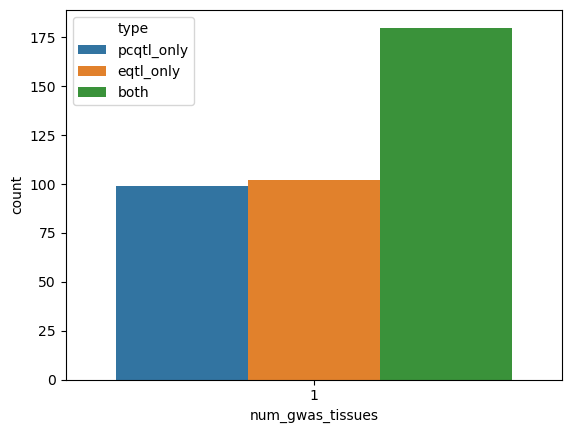

In [66]:
# number of tissues vs signal type
sns.countplot(coloc_sets, x='num_gwas_tissues', hue='type')


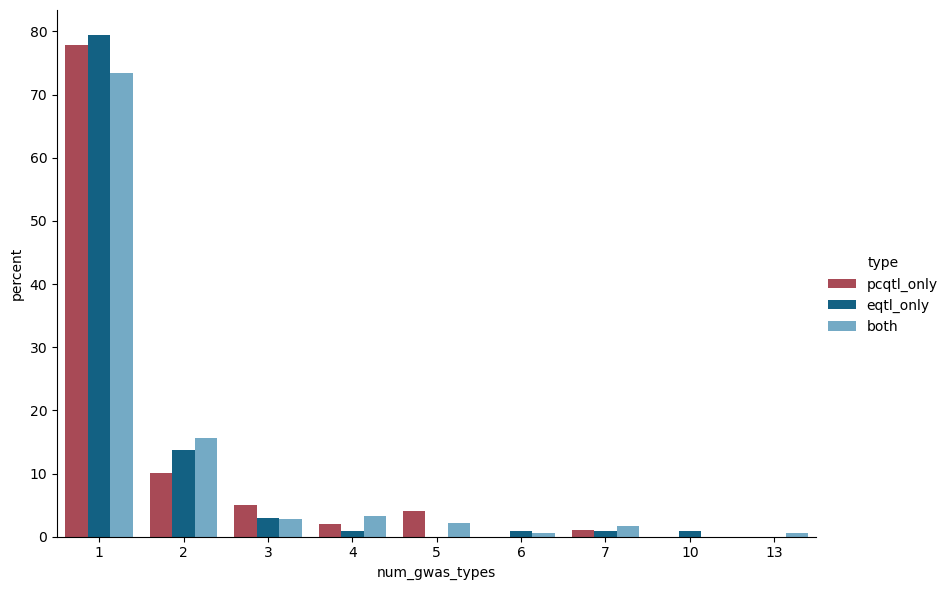

In [67]:
data_to_plot = coloc_sets.groupby('type')['num_gwas_types'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(data_to_plot, x='num_gwas_types',y='percent',hue='type',kind='bar',height=6, aspect=1.4, 
            hue_order=['pcqtl_only','eqtl_only', 'both'], 
            palette=('#B83A4B', '#016895', '#67AFD2'))


<AxesSubplot: xlabel='num_qtl_tissues', ylabel='count'>

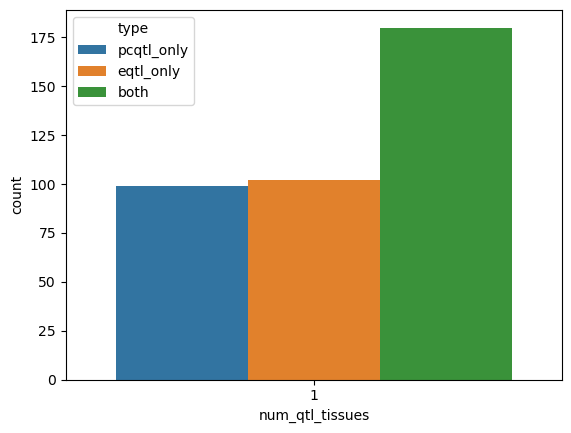

In [68]:
sns.countplot(coloc_sets, x='num_qtl_tissues', hue='type')

/local/scratch/klawren/slrmtmp.46831810/ipykernel_35679/2010808585.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


Text(0.5, 0, 'Number of colocalized QTLs')

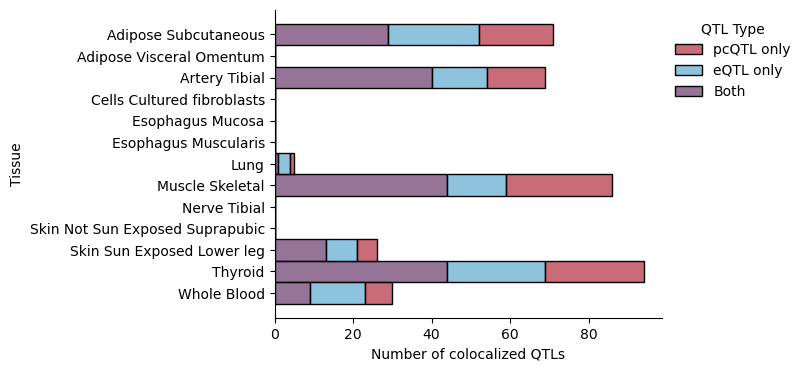

In [69]:
# histogram with qtl type
coloc_sets_explode = coloc_sets.explode('qtl_tissues')
coloc_sets_explode['tissue_id_ordered'] = pd.Categorical(coloc_sets_explode['qtl_tissues'], tissue_ids)

fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(coloc_sets_explode, y='tissue_id_ordered', hue='type', multiple='stack', 
             hue_order=['pcqtl_only','eqtl_only', 'both'], 
             palette=('#B83A4B', '#67AFD2', '#734675'), ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)
ax.set_ylabel('Tissue')

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
plt.gca().get_legend().set_frame_on(False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


ax.set_xlabel('Number of colocalized QTLs')


<AxesSubplot: xlabel='num_clusters', ylabel='count'>

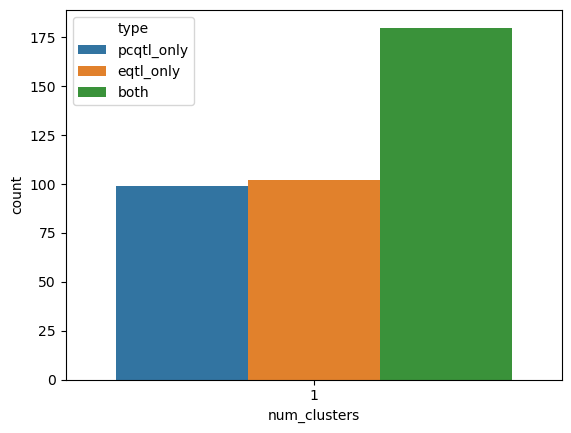

In [70]:
# ideally this should be all 1
sns.countplot(coloc_sets, x='num_clusters', hue='type')

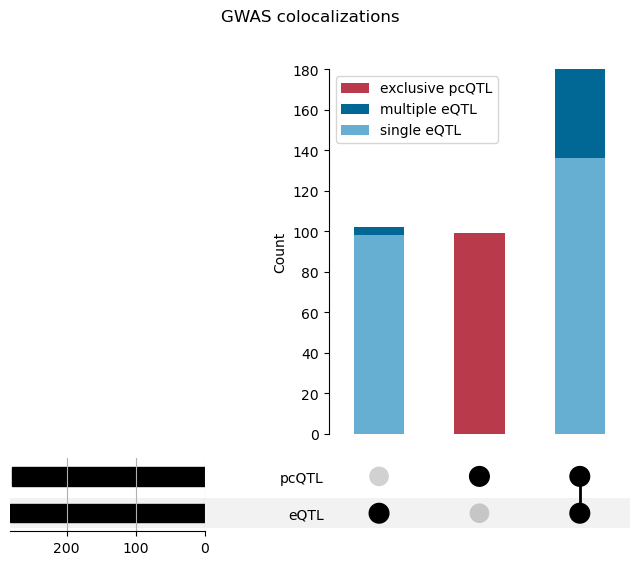

In [71]:
# make indicator columns 
coloc_sets['pcQTL'] = coloc_sets['num_pcqtl'] > 0
coloc_sets['eQTL'] = coloc_sets['num_eqtl'] > 0

# multiple egenes
coloc_sets['multiple_e_shared'] = coloc_sets['num_eqtl']>1  

upset_to_plot = coloc_sets.set_index('eQTL').set_index('pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations')
plt.show()

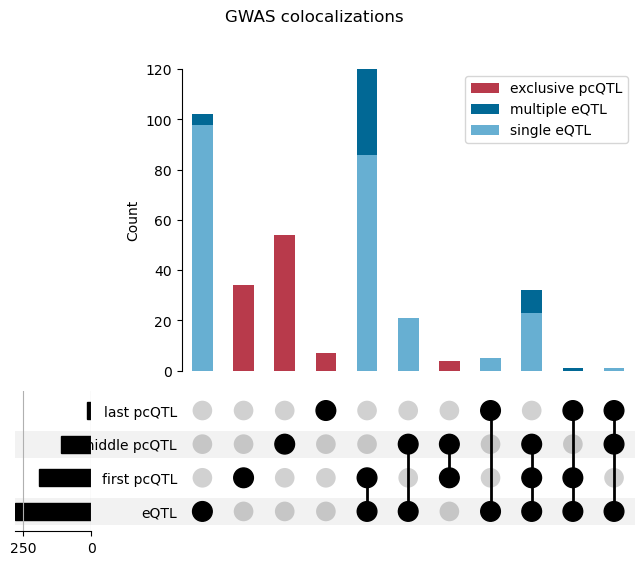

In [72]:
# make indicator columns 
coloc_sets['first pcQTL'] = coloc_sets['num_pc_first'] > 0
coloc_sets['middle pcQTL'] = coloc_sets['num_pc_middle'] > 0
coloc_sets['last pcQTL'] = coloc_sets['num_pc_last'] > 0



# multiple egenes
coloc_sets['multiple_e_shared'] = coloc_sets['num_eqtl']>1  

upset_to_plot = coloc_sets.set_index('eQTL').set_index('first pcQTL', append=True).set_index('middle pcQTL', append=True).set_index('last pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations')
plt.show()

what fraction of each colocalize?

In [73]:
#list of all qtls, not from overlap becuase I don't want credible sets
# the list of all with a signal just the h1, h3, and h4 from the coloc
gwas_coloc['cluster_size'] = gwas_coloc['cluster_id'].str.split('_').apply(len)
gwas_coloc['pc_num'] = np.where(gwas_coloc['qtl_id'].str.contains('pc'), gwas_coloc['qtl_id'].str.split('_pc').str[1] ,0).astype(int)
gwas_coloc['first_pc'] = gwas_coloc['pc_num'] == 1
gwas_coloc['last_pc'] = gwas_coloc['pc_num'] == gwas_coloc['cluster_size']
gwas_coloc['middle_pc'] = (gwas_coloc['pc_num'] > 1) & (gwas_coloc['pc_num'] != gwas_coloc['cluster_size'])

In [74]:
gwas_coloc['qtl_sig'] = (gwas_coloc['PP.H1.abf'] > coloc_cutoff) | (gwas_coloc['PP.H3.abf'] > coloc_cutoff) | (gwas_coloc['PP.H4.abf'] > coloc_cutoff)
gwas_coloc['coloc_sig'] = gwas_coloc['PP.H4.abf'] > coloc_cutoff
qtl_grouped = gwas_coloc.groupby(['qtl_id']).agg({'type':'first', 
                                    'qtl_sig':'sum', 
                                    'coloc_sig': 'sum', 
                                    'first_pc':'first',
                                    'middle_pc':'first',
                                    'last_pc':'first', 
                                    'cluster_id':'first'})

In [75]:
def get_frac_coloc(qtl_grouped):
    sig_count = {'eqtl':sum((qtl_grouped['type']=='eqtl')& (qtl_grouped['coloc_sig'] > 0)), 
                'first_pc': sum((qtl_grouped['first_pc'])& (qtl_grouped['coloc_sig'] > 0)), 
                'middle_pc': sum((qtl_grouped['middle_pc'])& (qtl_grouped['coloc_sig'] > 0)), 
                'last_pc': sum((qtl_grouped['last_pc'])& (qtl_grouped['coloc_sig'] > 0))}


    total_count = {'eqtl':sum((qtl_grouped['type']=='eqtl')& (qtl_grouped['qtl_sig'] > 0)), 
                'first_pc': sum((qtl_grouped['first_pc'])& (qtl_grouped['qtl_sig'] > 0)), 
                'middle_pc': sum((qtl_grouped['middle_pc'])& (qtl_grouped['qtl_sig'] > 0)), 
                'last_pc': sum((qtl_grouped['last_pc'])& (qtl_grouped['qtl_sig'] > 0))}

    frac_coloc = pd.DataFrame({'total_count':total_count, 'sig_count':sig_count})
    frac_coloc.reset_index(names=['qtl_type'], inplace=True)
    frac_coloc['frac_coloc'] = frac_coloc['sig_count']/frac_coloc['total_count']*100
    frac_coloc['frac_se'] = np.sqrt(frac_coloc['frac_coloc']/100*(1-frac_coloc['frac_coloc']/100)/frac_coloc['total_count'])*100
    frac_coloc['error'] = frac_coloc['frac_se']*2
    return frac_coloc

frac_coloc = get_frac_coloc(qtl_grouped)

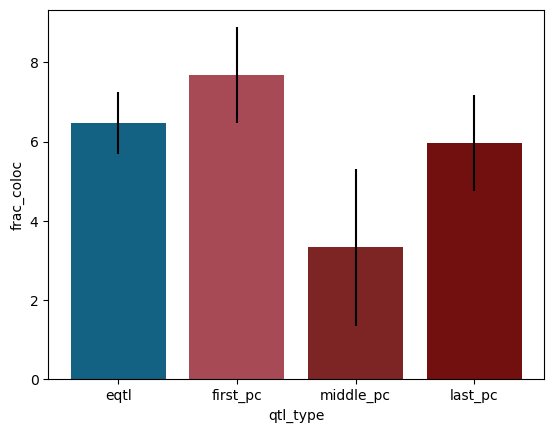

In [76]:
barplot = sns.barplot(frac_coloc, y='frac_coloc', x='qtl_type', hue='qtl_type', palette={'eqtl':'#016895', 'first_pc':'#B83A4B', 'middle_pc':'#8C1515', 'last_pc':'#820000'})
# Iterating over the bars and adding the error bars
for i, bar in enumerate(barplot.patches):
    barplot.errorbar(x=bar.get_x() + bar.get_width() / 2,
                     y=bar.get_height(),
                     yerr=frac_coloc['error'].iloc[i],
                     ecolor='black',
                     fmt='none')

In [77]:
cluster_grouped = qtl_grouped.groupby(['cluster_id', 'type']).agg({'coloc_sig':'sum', 'qtl_sig':'sum'}).reset_index()
sig_count = {'eqtl':sum((cluster_grouped['type']=='eqtl')& (cluster_grouped['coloc_sig'] > 0)), 
               'pcqtl': sum((cluster_grouped['type']=='pcqtl')& (cluster_grouped['coloc_sig'] > 0))}


total_count = {'eqtl':sum((cluster_grouped['type']=='eqtl')& (cluster_grouped['qtl_sig'] > 0)), 
               'pcqtl': sum((cluster_grouped['type']=='pcqtl')& (cluster_grouped['qtl_sig'] > 0))}

frac_coloc_cluster = pd.DataFrame({'total_count':total_count, 'sig_count':sig_count})
frac_coloc_cluster.reset_index(names=['qtl_type'], inplace=True)
frac_coloc_cluster['frac_coloc'] = frac_coloc_cluster['sig_count']/frac_coloc_cluster['total_count']*100
frac_coloc_cluster['frac_se'] = np.sqrt(frac_coloc_cluster['frac_coloc']/100*(1-frac_coloc_cluster['frac_coloc']/100)/frac_coloc_cluster['total_count'])*100
frac_coloc_cluster['error'] = frac_coloc_cluster['frac_se']*2

In [78]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(frac_coloc_cluster[['total_count', 'sig_count']].to_numpy())

print(f"P-value: {p}")
# Calculate standard errors
# SE = sqrt[ p(1 - p) / n ]
SE_eqtl = np.sqrt((0.14619493*(1-0.14619493))/1498)
SE_pcqtl = np.sqrt((0.14542837*(1-0.14542837))/1389)

print(f"Standard Error for eqtl: {SE_eqtl}")
print(f"Standard Error for pcqtl: {SE_pcqtl}")

P-value: 0.80580893507477
Standard Error for eqtl: 0.009128293887354961
Standard Error for pcqtl: 0.00945905347949597


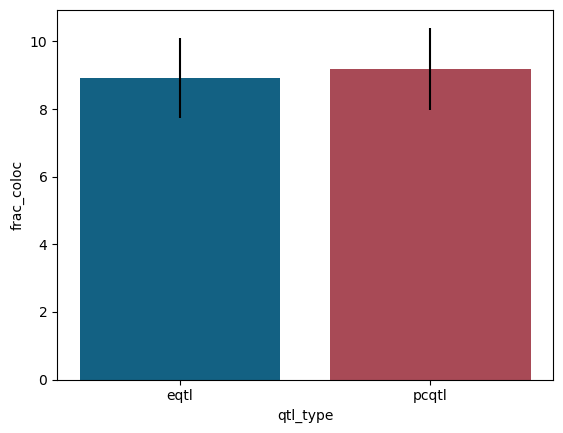

In [79]:
# group by cluster
barplot = sns.barplot(frac_coloc_cluster, y='frac_coloc', x='qtl_type', hue='qtl_type', palette={'eqtl':'#016895', 'pcqtl':'#B83A4B'})

# Iterating over the bars and adding the error bars
for i, bar in enumerate(barplot.patches):
    barplot.errorbar(x=bar.get_x() + bar.get_width() / 2,
                     y=bar.get_height(),
                     yerr=frac_coloc_cluster['error'].iloc[i],
                     ecolor='black',
                     fmt='none')

### add in cluster information

In [80]:
clusters = [load_clusters_annotated(config, tissue_id) for tissue_id in tissue_ids]
clusters = pd.concat([df.assign(tissue_id=n) for df, n in zip(clusters, tissue_ids)])

In [81]:
(coloc_sets['num_clusters'] != 1).sum()

0

In [82]:
# each set is only one cluster, so add in that informaiton
coloc_sets_cluster_annot = pd.merge(clusters, coloc_sets.explode(['qtl_clusters', 'qtl_tissues']), left_on=['cluster_id', 'tissue_id'], right_on=['qtl_clusters', 'qtl_tissues'], how='outer')
coloc_sets_cluster_annot['has_coloc'] = ~coloc_sets_cluster_annot['type'].isna()
coloc_sets_cluster_annot['type'] = np.where(coloc_sets_cluster_annot['type'].isna(), 'no_coloc', coloc_sets_cluster_annot['type'])
coloc_sets_cluster_annot

,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue,cluster_size,cluster_tss_size,...,num_pc_first,num_pc_middle,num_pc_last,pcQTL,eQTL,multiple_e_shared,first pcQTL,middle pcQTL,last pcQTL,has_coloc
0,9,"ENSG00000203786.6,ENSG00000197084.5,ENSG000001...",0.722222,0.351570,0.373850,-0.027194,1,Adipose_Subcutaneous,346623,346623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,5,"ENSG00000168765.16,ENSG00000213366.12,ENSG0000...",1.000000,0.475357,0.475357,NaN,1,Adipose_Subcutaneous,119347,84957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,4,"ENSG00000121310.16,ENSG00000116171.17,ENSG0000...",0.833333,0.293622,0.293622,NaN,1,Adipose_Subcutaneous,246722,215420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,4,"ENSG00000117228.9,ENSG00000162645.12,ENSG00000...",0.833333,0.295550,0.295550,NaN,1,Adipose_Subcutaneous,146613,133572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,4,"ENSG00000162687.16,ENSG00000000971.15,ENSG0000...",1.000000,0.346542,0.346542,NaN,1,Adipose_Subcutaneous,606410,210532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12048,2,"ENSG00000128271.21,ENSG00000100024.14",1.000000,0.260535,0.260535,NaN,22,Whole_Blood,110511,76228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12049,2,"ENSG00000099991.17,ENSG00000099994.10",1.000000,0.218315,0.218315,NaN,22,Whole_Blood,177918,170067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12050,2,"ENSG00000183773.15,ENSG00000099949.18",1.000000,0.221136,0.221136,NaN,22,Whole_Blood,33930,14354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12051,2,"ENSG00000100075.9,ENSG00000070371.15",1.000000,0.216789,0.216789,NaN,22,Whole_Blood,116141,112886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


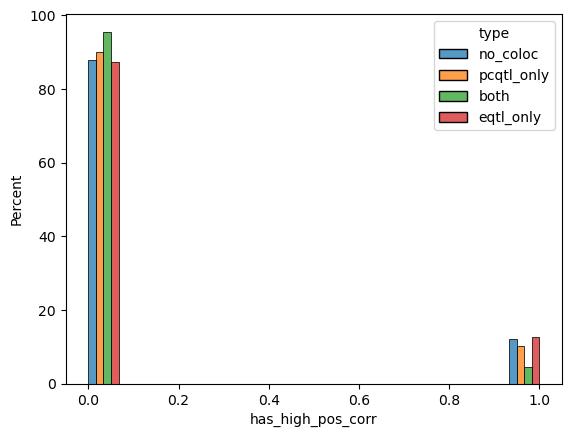

In [85]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='has_high_pos_corr', stat='percent', common_norm=False, multiple='dodge')


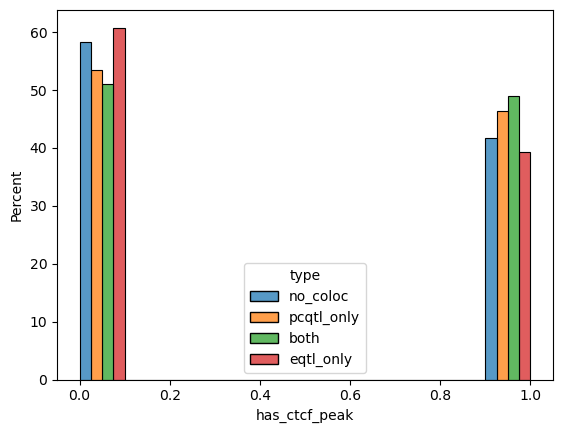

In [86]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='has_ctcf_peak', stat='percent', common_norm=False, bins = 10, multiple='dodge')


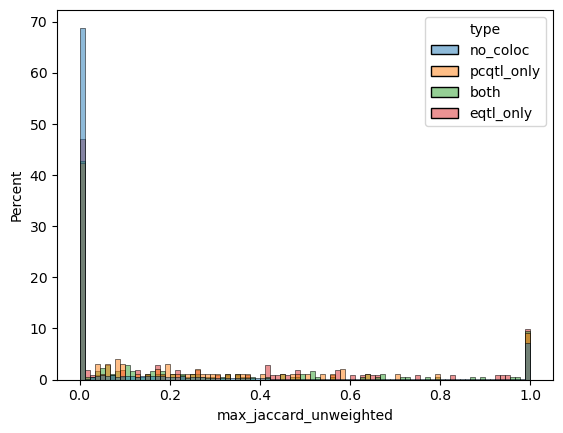

In [87]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='max_jaccard_unweighted', stat='percent', common_norm=False)


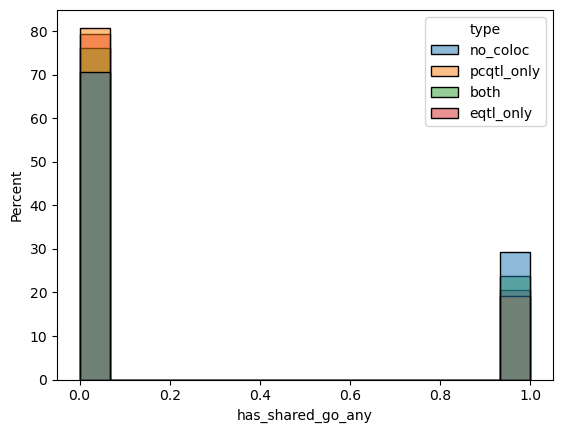

In [88]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='has_shared_go_any', stat='percent', common_norm=False)


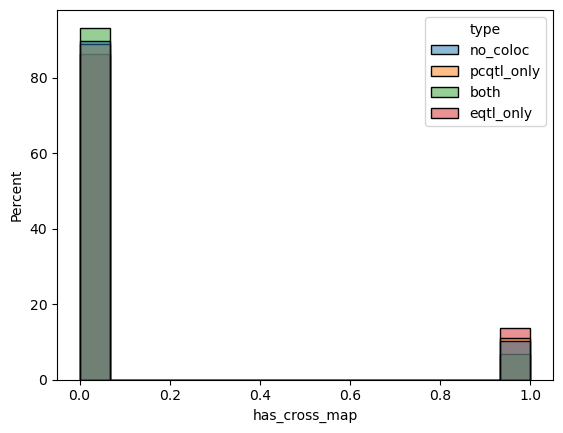

In [89]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='has_cross_map', stat='percent', common_norm=False)


/local/scratch/klawren/slrmtmp.46650329/ipykernel_61199/3062742416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coloc_sets_nocrossmap['first pcQTL'] = coloc_sets_nocrossmap['num_pc_first'] > 0
/local/scratch/klawren/slrmtmp.46650329/ipykernel_61199/3062742416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coloc_sets_nocrossmap['middle pcQTL'] = coloc_sets_nocrossmap['num_pc_middle'] > 0
/local/scratch/klawren/slrmtmp.46650329/ipykernel_61199/3062742416.py:5: SettingWithCopyWarning: 
A value is t

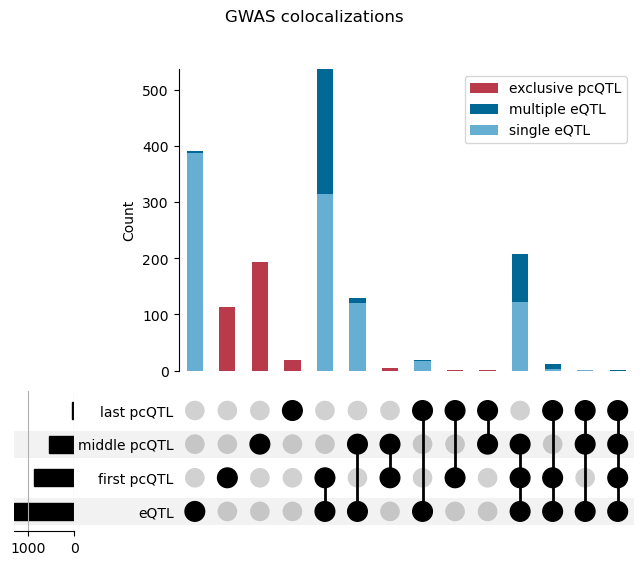

In [72]:
# make indicator columns 
coloc_sets_nocrossmap = coloc_sets_cluster_annot[(~coloc_sets_cluster_annot['has_cross_map']) & coloc_sets_cluster_annot['has_coloc']]
coloc_sets_nocrossmap['first pcQTL'] = coloc_sets_nocrossmap['num_pc_first'] > 0
coloc_sets_nocrossmap['middle pcQTL'] = coloc_sets_nocrossmap['num_pc_middle'] > 0
coloc_sets_nocrossmap['last pcQTL'] = coloc_sets_nocrossmap['num_pc_last'] > 0

# multiple egenes
coloc_sets_nocrossmap['multiple_e_shared'] = coloc_sets_nocrossmap['num_eqtl']>1  
upset_to_plot = coloc_sets_nocrossmap.set_index('eQTL').set_index('first pcQTL', append=True).set_index('middle pcQTL', append=True).set_index('last pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations')
plt.show()

/local/scratch/klawren/slrmtmp.46650329/ipykernel_61199/1926852395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coloc_sets_nocrossmap['pcQTL'] = coloc_sets_nocrossmap['num_pcqtl'] > 0
/local/scratch/klawren/slrmtmp.46650329/ipykernel_61199/1926852395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coloc_sets_nocrossmap['eQTL'] = coloc_sets_nocrossmap['num_eqtl'] > 0


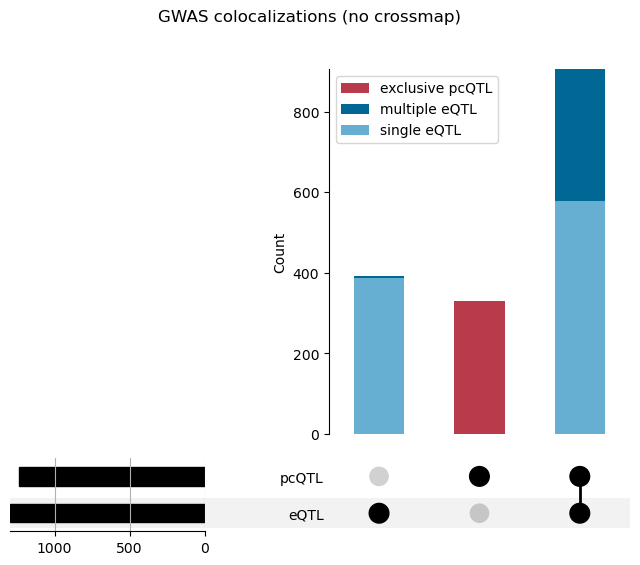

In [73]:
# make indicator columns 
coloc_sets_nocrossmap['pcQTL'] = coloc_sets_nocrossmap['num_pcqtl'] > 0
coloc_sets_nocrossmap['eQTL'] = coloc_sets_nocrossmap['num_eqtl'] > 0
upset_to_plot = coloc_sets_nocrossmap.set_index('eQTL').set_index('pcQTL', append=True)

upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
upset_to_plot['multiple_e_shared_label'] = np.where(upset_to_plot['num_eqtl'] > 0, upset_to_plot['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset_to_plot, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('GWAS colocalizations (no crossmap)')
plt.show()

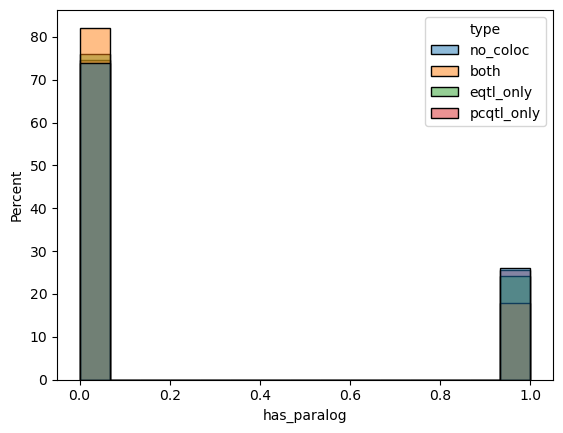

In [74]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='has_paralog', stat='percent', common_norm=False)


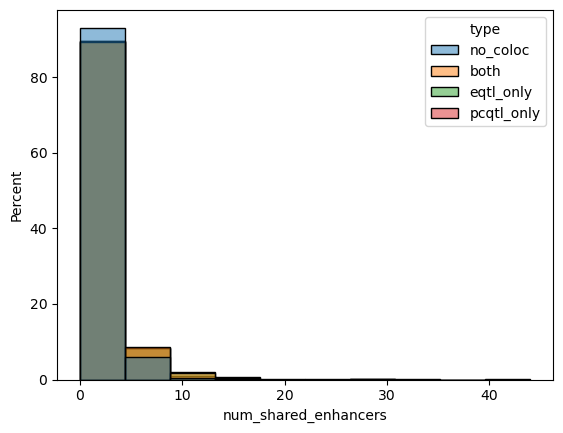

In [75]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='num_shared_enhancers', stat='percent', common_norm=False, bins=10)


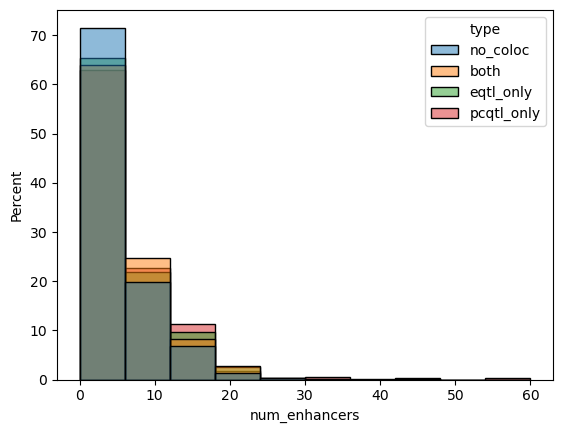

In [76]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='num_enhancers', stat='percent', common_norm=False, bins=10)


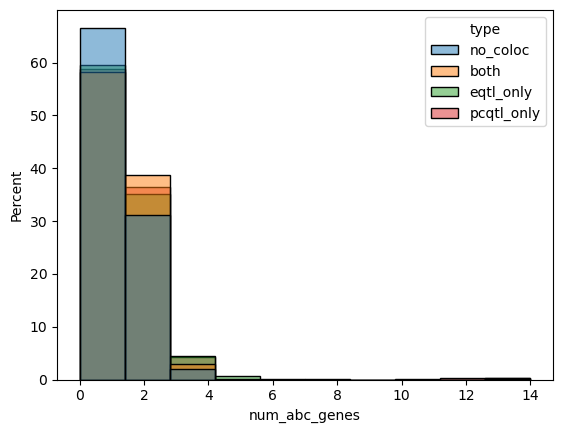

In [77]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='num_abc_genes', stat='percent', common_norm=False, bins=10)


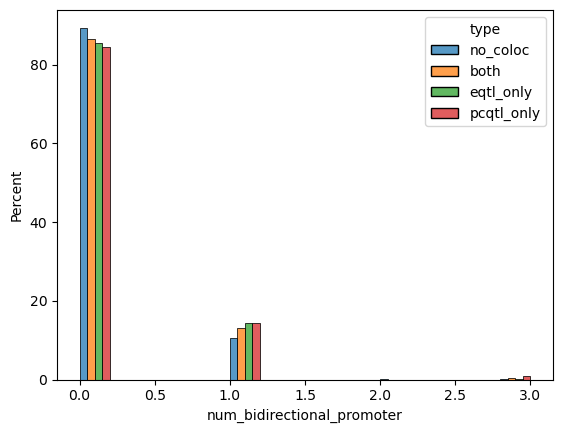

In [78]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='num_bidirectional_promoter', stat='percent', common_norm=False, multiple='dodge')


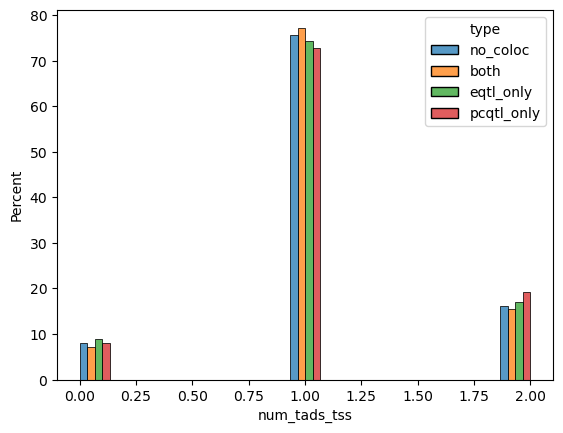

In [79]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='num_tads_tss', stat='percent', common_norm=False, multiple='dodge')


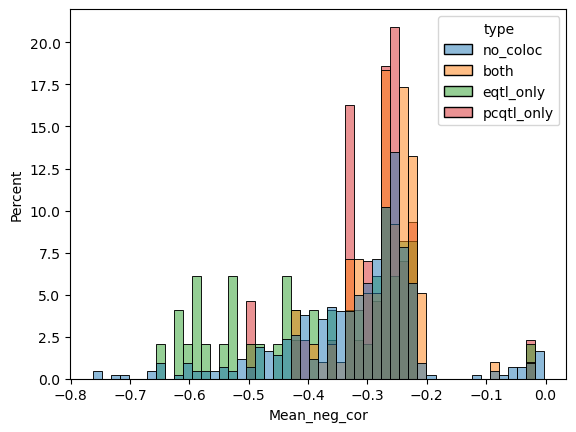

In [80]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='Mean_neg_cor', stat='percent', common_norm=False,bins=50)


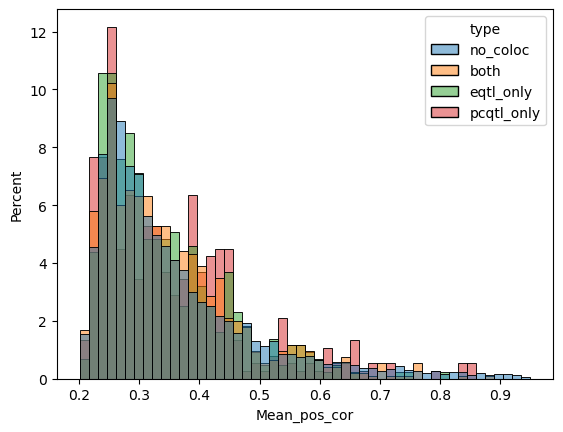

In [81]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='Mean_pos_cor', stat='percent', common_norm=False,bins=50)


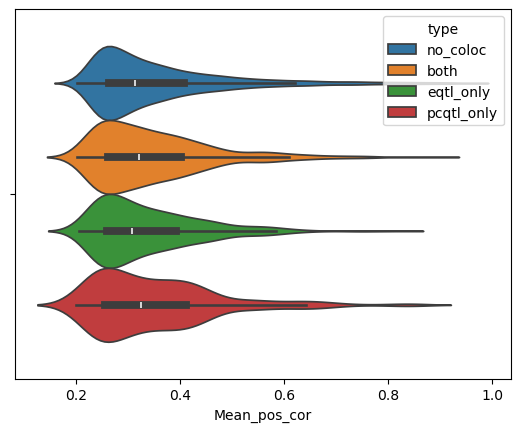

In [82]:
ax=sns.violinplot(data=coloc_sets_cluster_annot, hue='type', x='Mean_pos_cor')


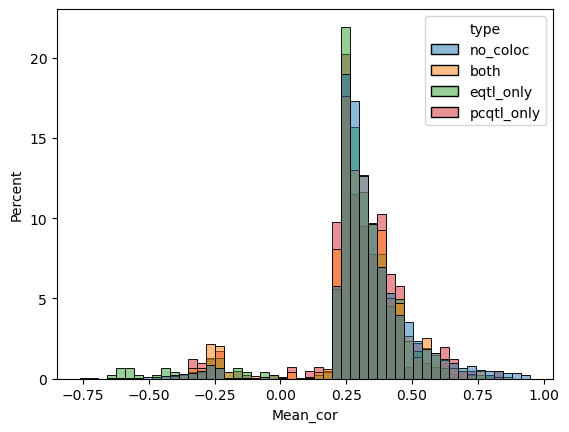

In [83]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='Mean_cor', stat='percent', common_norm=False,bins=50)


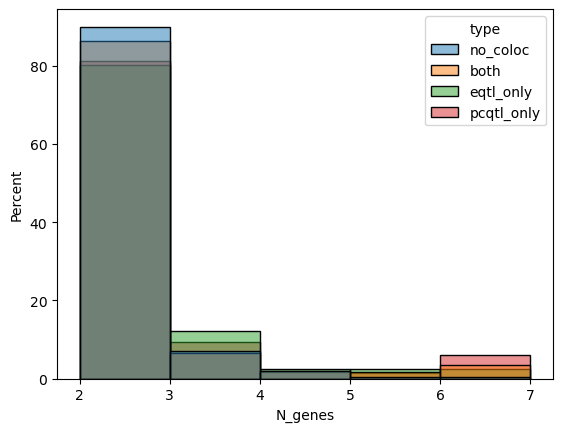

In [84]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='type', x='N_genes', stat='percent', common_norm=False, bins=range(2,8))


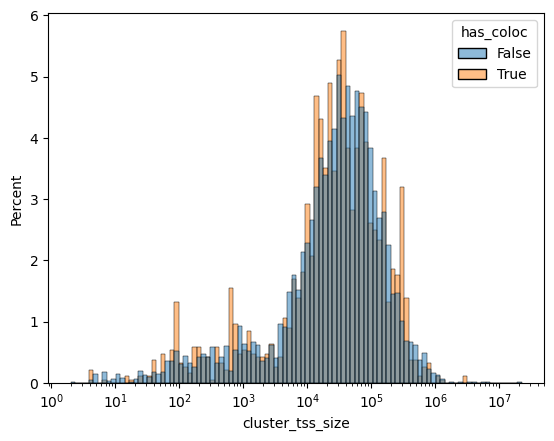

In [85]:
ax=sns.histplot(data=coloc_sets_cluster_annot, hue='has_coloc', x='cluster_tss_size', stat='percent', common_norm=False, bins=100, log_scale=True)


## add log odds

## coloc over correlaitons

### qtl annotations
do pcqtls that coloc have different annotations than eqtl that coloc?

can't do this without susie because we don't know which variant is driving the shared signal